In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function
from torchsummary import summary

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from unet import UNet

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

# U-Net

In [2]:
EPOCH_NUM = 1
BATCH_SIZE = 2
LR = 0.001
INPUT_SIZE = 512 # 输入网络的大小而非图片大小
OUTPUT_SIZE = 324

root_path = 'D://Data/massachusetts-roads-dataset/'
# root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select_parts/"

DIR_CHECKPOINT = 'checkpoints/'

classes = ['background', 'road']
colormap = [[0 , 0, 0], [255, 255, 255]]

In [3]:
class DoubleConv(nn.Module):
    # 输入输出的 feature map 个数可以控制
    # 但是图片具体大小根据图片本身大小决定
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [115]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
        x2 = x2[:,:, (diffY // 2): -(diffY - diffY // 2), (diffY // 2): -(diffX - diffX // 2)]
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [116]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [144]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels # 图片的通道数（最初输入）
        self.n_classes = n_classes # 最终类别墅（最终输出）
        self.bilinear = bilinear # -- 暂不用

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [151]:
# tnet = UNet(3, 1, False)
# summary(tnet, (3, 512, 512))

In [10]:
img = cv2.imread('D:/Data/massachusetts-roads-dataset/tiff_select_parts/train/10078660_15_p1.tiff')
label = cv2.imread('D:/Data/massachusetts-roads-dataset/tiff_select_parts/train_labels/10078660_15_p1.tif')

In [11]:
img.shape, label.shape

((750, 750, 3), (750, 750, 3))

In [12]:
transform = transforms.Compose([transforms.Resize([512, 512], 0),
                                transforms.ToTensor(),])
img_tensor, label_tensor = transform(Image.fromarray(img)), transform(Image.fromarray(label))

In [76]:
# plt.imshow(img_tensor.permute(1, 2, 0).numpy())

In [77]:
# plt.imshow(label_tensor.permute(1, 2, 0).numpy())

## Evaluation

- Dice coefficient: 
    - measure the similarity between two set.
    - $\frac{2|X\cap Y|}{|X| + |Y|}$
- Dice loss: $1 - \frac{2|X\cap Y|}{|X| + |Y|}$

In [15]:
class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    # 在进入 forward 之前，所有变量都会被转化为 tensor
    def forward(self, input, target):
        self.save_for_backward(input, target) # tensor 转化为变量保存到后续操作
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):
        input, target = self.saved_variables
        grad_input = grad_target = None

        # 判断 input 是否需要求梯度
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        # 判断 target 是否需要求梯度
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    # 在合适的设备上初始化一个1*1零向量
    # 同一个 batch 中 dice loss 取平均
    s = torch.FloatTensor(1).cuda().zero_() if input.is_cuda else torch.FloatTensor(1).zero_()
    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])
    return s / (i + 1)

In [16]:
def eval_net(net, loader, device):
    """Evaluation without the densecrf with the dice coefficient"""
    # 关闭 batchnorm 和 dropout
    net.eval() # 仔细看
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    n_val = len(loader)  # the number of batch
    tot = 0

    # 括号里设置文字输出信息
    with tqdm(total = n_val, desc='Validation round', unit='batch', leave=False) as pbar:
        # 对于每个 batch
        for batch in loader:
            imgs, true_masks = batch[0], batch[1]
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=mask_type)

            # 不需要追踪梯度变化，不需要进行反向传播，提升速度
            with torch.no_grad():
                # 得到模型预测结果
                mask_pred = net(imgs)

            # 不同类别预测结果损失累加
            if net.n_classes > 1:
                tot += F.cross_entropy(mask_pred, true_masks).item()
            else:
                pred = torch.sigmoid(mask_pred)
                pred = (pred > 0.5).float()
                tot += dice_coeff(pred, true_masks).item()
            pbar.update()

    net.train()
    return tot / n_val

## Data Processing

In [28]:
# 获取图片及其标签路径（图片和标签配对）
def read_images(root_path, train = True):
    if train:
        data = [root_path + "/train/" + file_name for file_name in list(os.walk(road_path+"/train/"))[0][2]]
        labels = [root_path + "/train_labels/" + file_name for file_name in list(os.walk(road_path+"/train_labels/"))[0][2]]
    else:
        data = [root_path + "/val/" +file_name for file_name in list(os.walk(road_path+"/val/"))[0][2]]
        labels = [root_path + "/val_labels/" + file_name for file_name in list(os.walk(road_path+"/val_labels/"))[0][2]]
    return data, labels

# 原图 0-255，tensor 中 0-1
def change_to_tensor(img, label, tensor_size, output_size):
    img = cv2.imread(img)
    label = cv2.imread(label)
    # 对于每一种类别
    for i, cm in enumerate(colormap):
        # 每个通道都符合条件（在本例子中实际只限制一个通道即可）
        label[(label[:, :, 0] == cm[0]) & (label[:, :, 1] == cm[1]) & (label[:, :, 2] == cm[2])] = i * 255
    label = label[:, :, 0] # 只取一个通道结果作为标签
    
    transform_data = transforms.Compose([transforms.Resize([tensor_size, tensor_size], 0),
                                    transforms.ToTensor(),])
    transform_label = transforms.Compose([transforms.Resize([output_size, output_size], 0),
                                    transforms.ToTensor(),])
    img_tensor, label_tensor = transform_data(Image.fromarray(img)), transform_label(Image.fromarray(label))
    return img_tensor, label_tensor

class RoadDataset(Dataset):
    def __init__(self, root_path, train, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        super(RoadDataset, self).__init__()
        
        self.data_list, self.label_list = read_images(root_path = root_path, train = train)
        self.len = len(self.data_list)
        print('Read '+ str(self.len)+' images')
    
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img, label = change_to_tensor(img, label, self.input_size, self.output_size)
        return img, label
    
    def __len__(self):
        return self.len

## Train

In [29]:
def train_net(net, device, train_dataset, val_dataset, epochs = EPOCH_NUM, lr = LR, save_cp = True,
             batch_size = BATCH_SIZE):

    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size = 1, shuffle=False)
    
    # 每轮 evaluation 检验的 batch 个数
    n_val = len(val_dataset)
    # 每轮 train 检验的 batch 个数
    n_train = len(train_dataset)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{BATCH_SIZE}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
    ''')
#     换 SGD，图像用 SGD Adam，收敛速度而非效果
#     optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    # 在发现loss不再降低或者acc不再提高之后，降低学习率。patience 含义：不再减小（或增大）的累计次数
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total = n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                
                imgs = batch[0]
                true_masks = batch[1]
                
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # 对于每个 batch 都要更新一次参数空间
                optimizer.zero_grad()
                loss.backward()
                # 防止梯度爆炸，设置梯度截断
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                # 每个 batch 结束更新一次进度条，迭代器内部计数器累加 batch 的大小
                pbar.update(imgs.shape[0])
                global_step += 1
                
                # 每训练 10 个 batch 在 tensorboard 中记录一次
                if global_step % (n_train // (10 * batch_size) + 1) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(DIR_CHECKPOINT)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       DIR_CHECKPOINT + f'unet_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()

In [73]:
# net = UNet(n_channels = 3, n_classes = 1, bilinear = False)
# t = net(img_tensor.unsqueeze(0))
# t = (torch.sigmoid(t).squeeze(0) > 0.5) * 255
# t = t.detach().numpy()
# t = np.concatenate([t, t, t])
# t = t.transpose((1, 2, 0))
# plt.imshow(t)

In [74]:
# net = UNet(n_channels = 3, n_classes = 1, bilinear = False)
# t = net(img_tensor.unsqueeze(0))
# t = (torch.sigmoid(t).squeeze(0) > 0.5) * 255
# t = t.detach().numpy()
# t = np.concatenate([t, t, t])
# t = t.transpose((1, 2, 0))
# plt.imshow(t)

In [75]:
# plt.imshow(label)

In [110]:
net = UNet(n_channels = 3, n_classes = 1, bilinear = False)
device = torch.device('cuda' if torch.
                      cuda.is_available() else 'cpu')
if(device == 'cuda'):
    net = net.cuda()

train_dataset = RoadDataset(road_path, True, INPUT_SIZE, OUTPUT_SIZE)
val_dataset = RoadDataset(road_path, False, INPUT_SIZE, OUTPUT_SIZE)

Read 368 images
Read 56 images


In [114]:
train_net(net, device, train_dataset, val_dataset)

Epoch 1/1:   4%|▍         | 16/368 [01:14<27:19,  4.66s/img, loss (batch)=0.643]


KeyboardInterrupt: 

In [36]:
torch.save(net.state_dict(), DIR_CHECKPOINT + 'unet_epoch1.pth')

In [37]:
torch.save(net.state_dict(), DIR_CHECKPOINT + 'unet_epoch2.pth')

## Predict

In [120]:
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.load_state_dict(torch.load(DIR_CHECKPOINT + 'unet_epoch1.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device=device)

<All keys matched successfully>

In [32]:
# summary(net, (3, 578, 578))

In [72]:
def predict_img(net, img, device):
    net.eval()
    if len(img.shape) == 3:
        img = img.unsqueeze(0)
        
    with torch.no_grad():
        if net.n_classes > 1:
            pred = net(img.unsqueeze(dim=0))
            pred = F.softmax(pred, dim=1).max(dim = 1)[1]
            pred_img = torch.cat((pred, pred, pred))
            pred_img = pred_img.permute((1, 2, 0)) * 255
        else:
            pred = net(img)
            pred = (torch.sigmoid(pred).squeeze(0) > 0.5) * 255
            pred = pred.detach().numpy()
            pred_img = np.concatenate([pred, pred, pred]).transpose((1, 2, 0))
            
    return pred_img

In [73]:
pred = predict_img(net, img_tensor, device)

In [74]:
pred.shape

(388, 388, 3)

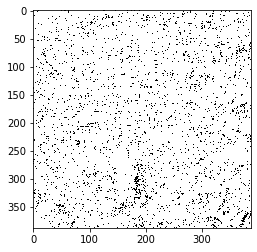

In [75]:
plt.imshow(pred)

In [78]:
pred.flatten().sum().item()/pred.flatten().shape[0]/255

0.9404825167392922

In [255]:
pred.sha

torch.Size([1, 388, 388])

In [228]:
img = 'D:/Data/massachusetts-roads-dataset/tiff_excel/train/17428900_15.tiff'
label = 'D:/Data/massachusetts-roads-dataset/tiff_excel/train_labels/17428900_15.tif'
img, label = change_to_tensor(img, label, INPUT_SIZE)
img.unsqueeze(0).shape

torch.Size([1, 3, 578, 578])

In [256]:
pred = net(img.unsqueeze(dim=0))
t = F.softmax(pred, dim=1)
t = t.max(dim=1)[1]

In [258]:
t.shape

torch.Size([1, 388, 388])

In [262]:
torch.cat((t, t)).unsqueeze(0).shape

torch.Size([1, 2, 388, 388])

In [218]:
pred = net(img.unsqueeze(dim = 0))
t = F.softmax(pred, dim=1)
t.max(dim=1)

torch.return_types.max(
values=tensor([[[0.5004, 0.5005, 0.5009,  ..., 0.5005, 0.5007, 0.5005],
         [0.5006, 0.5006, 0.5002,  ..., 0.5011, 0.5007, 0.5003],
         [0.5001, 0.5003, 0.5006,  ..., 0.5003, 0.5005, 0.5005],
         ...,
         [0.5000, 0.5002, 0.5002,  ..., 0.5009, 0.5010, 0.5010],
         [0.5002, 0.5001, 0.5001,  ..., 0.5007, 0.5009, 0.5009],
         [0.5002, 0.5008, 0.5005,  ..., 0.5011, 0.5012, 0.5007]]],
       grad_fn=<MaxBackward0>),
indices=tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 1, 0,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]))

In [86]:
t.squeeze().shape

torch.Size([2, 388, 388])

In [91]:
t.squeeze(0).max(dim=0)

torch.return_types.max(
values=tensor([[0.4468, 0.4418, 0.5084,  ..., 0.4056, 0.4508, 0.4752],
        [0.4375, 0.4722, 0.5347,  ..., 0.4802, 0.4503, 0.5240],
        [0.4584, 0.4502, 0.4986,  ..., 0.5917, 0.4890, 0.4494],
        ...,
        [0.4935, 0.3981, 0.4046,  ..., 0.5127, 0.4666, 0.4579],
        [0.5058, 0.4685, 0.4194,  ..., 0.4363, 0.4114, 0.4734],
        [0.4549, 0.4499, 0.4640,  ..., 0.4177, 0.4350, 0.3620]],
       grad_fn=<MaxBackward0>),
indices=tensor([[0, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 0,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 1, 1, 1]]))